# **Tarea 4 - Sequence to Sequence 📚**

**Procesamiento de Lenguaje Natural (CC6205-1 - Otoño 2024)**

## Tarjeta de identificación

**Nombres:** ```<Completar aquí>```

**Fecha límite de entrega 📆:** 09/07.

**Tiempo estimado de dedicación:** 4 horas


## Instrucciones

Bienvenid@s a la tercera tarea en el curso de Natural Language Processing (NLP). Esta tarea tiene como objetivo evaluar los contenidos teóricos de las últimas semanas de clases posteriores a la Tarea 3, enfocado en **Sequence-to-Sequence + Attention**. Si aún no has visto las clases, se recomienda visitar los links de las referencias.

* La tarea es en **grupo** (maximo hasta 3 personas).
* La entrega es a través de u-cursos a más tardar el día estipulado arriba.
* El formato de entrega es este mismo Jupyter Notebook.
* Al momento de la revisión su código será ejecutado. Por favor verifiquen que su entrega no tenga errores de compilación.
* Completar la tarjeta de identificación. Sin ella no podrá tener nota.
* Recomendamos mirar el enunciado completo antes de empezar la tarea, para tener una idea más completa de lo que se pide.

## Material de referencia

Diapositivas del curso 📄
    
- [Sequence-to-Sequence + Attention](https://github.com/dccuchile/CC6205/blob/master/slides/NLP-seq2seq.pdf)
- [Transformer](https://github.com/dccuchile/CC6205/blob/master/slides/NLP-transformer.pdf)

Videos del curso 📺

- [Sequence-to-Sequence + Attention](https://www.youtube.com/watch?v=OpKxRjISqmM&list=PLppKo85eGXiXIh54H_qz48yHPHeNVJqBi&index=35)
- [Transformer](https://www.youtube.com/watch?v=8RE23Uq8rU0)

## Traductor con arquitectura Encoder-Decoder con RNNs
En esta sección crearemos nuestro propio traductor con la arquitecura Encoder-Decoder con RNNs + Attention vista en clases.

In [ ]:
## Importamos librerías

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

### Preparación del dataset y tokenización (0.5 pt.)

Utilizaremos un dataset de pares de oraciones en inglés y castellano.

In [ ]:
!wget https://www.manythings.org/anki/spa-eng.zip
!unzip spa-eng.zip

--2024-06-25 23:16:45--  https://www.manythings.org/anki/spa-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5420295 (5.2M) [application/zip]
Saving to: 'spa-eng.zip.1'

spa-eng.zip.1       100%[===================>]   5.17M  26.1MB/s    in 0.2s    

2024-06-25 23:16:46 (26.1 MB/s) - 'spa-eng.zip.1' saved [5420295/5420295]

Archive:  spa-eng.zip
replace _about.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


Vamos a crear una clase que nos permita procesar mejor cada idioma del corpus. Essto nos será útil para manejar dos vocabularios distintos.

In [ ]:
SOS_token = 0
EOS_token = 1

class Lang:
  def __init__(self, name):
    self.name = name
    self.word2index = {}
    self.word2count = {}
    self.index2word = {0: "*", 1: "STOP"}
    self.n_tokens = 2  # * y STOP

  def add_sentence(self, sentence):
    for word in sentence.split(' '):
      self.add_word(word)

  def add_word(self, word):
    if word not in self.word2index:
      self.word2index[word] = self.n_tokens
      self.word2count[word] = 1
      self.index2word[self.n_tokens] = word
      self.n_tokens += 1
    else:
      self.word2count[word] += 1

In [ ]:
Escriba acá funciones para leer, procesar y filtar el dataset según estime.


In [ ]:
# Minúsculas, puntuación y remoción de caracteres que no son letras
# Puede añadir cualquier otro preprocesamiento que estime conveniente
def normalize_string(s):
  s = unicodedata.normalize('NFC', s) # Normalización de caracteres unicode
  s = s.lower().strip()
  s = re.sub(r"([.!?])", r" \1", s)
  s = re.sub(r"[^a-zA-Z!?áéíóúñ´]+", r" ", s)
  return s.strip()

In [ ]:
MAX_LENGTH = 10

def read_dataset(path, reverse=False):

  # Read the file and split into lines
  lines = open(path, encoding='utf-8').\
    read().strip().split('\n')

  # Split every line into pairs and normalize
  pairs = [[normalize_string(s) for s in l.split('\t')][:2] for l in lines]

  # Reverse pairs, make Lang instances
  if reverse:
    pairs = [list(reversed(p)) for p in pairs]
    input_lang = Lang("spa")
    output_lang = Lang("eng")
  else:
    input_lang = Lang("eng")
    output_lang = Lang("spa")

  return input_lang, output_lang, pairs

def filter_pairs(pairs, max_length):
  return [p for p in pairs if len(p[0].split(' ')) < max_length and \
                len(p[1].split(' ')) < max_length]


In [ ]:
def read_langs(lang1, lang2, reverse=False):
  input_lang, output_lang, pairs = read_dataset("spa.txt", reverse)
  print(f"Total de oraciones en dataset: {len(pairs)}")
  pairs = filter_pairs(pairs, MAX_LENGTH)
  print(f"Reducido a: {len(pairs)}")
  for pair in pairs:
    input_lang.add_sentence(pair[0])
    output_lang.add_sentence(pair[1])
  print(f"Tamaño vocab {input_lang.name}: {input_lang.n_tokens}")
  print(f"Tamaño vocab {output_lang.name}: {output_lang.n_tokens}")
  return input_lang, output_lang, pairs

input_lang, output_lang, pairs = read_langs('eng', 'spa', True)
print(random.choice(pairs))

Total de oraciones en dataset: 141543
Reducido a: 119626
Tamaño vocab spa: 24306
Tamaño vocab eng: 12105
['yo amo a mi patria', 'i love my country']


### Encoder (1.5 pt.)
Implemente una red Encoder utilizando redes neuronales recurrentes.

In [ ]:
# Garantizar reproducibilidad de los experimentos
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
class EncoderRNN(nn.Module):
  def __init__(self, input_size, hidden_size, dropout_p=0.1):
    super(EncoderRNN, self).__init__()
    self.hidden_size = hidden_size

    self.embedding = nn.Embedding(input_size, hidden_size)
    self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
    self.dropout = nn.Dropout(dropout_p)

  def forward(self, input):
    embedded = self.dropout(self.embedding(input))
    output, hidden = self.gru(embedded)
    return output, hidden

### Attention Decoder (2 pt.)

Ahora diseñe un mecanismo de atención según estime conveniente y otra red que servirá de decoder con el modelo de attention. Utilice la predicción objetivo (en caso de existir) como siguiente input de cada oración para la etapa de entrenamiento (teacher forcing).

In [ ]:
class BahdanauAttention(nn.Module):
  def __init__(self, hidden_size):
    super(BahdanauAttention, self).__init__()
    self.Wa = nn.Linear(hidden_size, hidden_size)
    self.Ua = nn.Linear(hidden_size, hidden_size)
    self.Va = nn.Linear(hidden_size, 1)

  def forward(self, query, keys):
    scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
    scores = scores.squeeze(2).unsqueeze(1)

    weights = F.softmax(scores, dim=-1)
    context = torch.bmm(weights, keys)

    return context, weights

class AttnDecoderRNN(nn.Module):
  def __init__(self, hidden_size, output_size, dropout_p=0.1):
    super(AttnDecoderRNN, self).__init__()
    self.embedding = nn.Embedding(output_size, hidden_size)
    self.attention = BahdanauAttention(hidden_size)
    self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
    self.out = nn.Linear(hidden_size, output_size)
    self.dropout = nn.Dropout(dropout_p)

  def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
    batch_size = encoder_outputs.size(0)
    decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
    decoder_hidden = encoder_hidden
    decoder_outputs = []
    attentions = []

    for i in range(MAX_LENGTH):
      decoder_output, decoder_hidden, attn_weights = self.forward_step(
        decoder_input, decoder_hidden, encoder_outputs
      )
      decoder_outputs.append(decoder_output)
      attentions.append(attn_weights)

      if target_tensor is not None:
        # Teacher forcing: Feed the target as the next input
        decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
      else:
        # Without teacher forcing: use its own predictions as the next input
        _, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze(-1).detach()  # detach from history as input

    decoder_outputs = torch.cat(decoder_outputs, dim=1)
    decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
    attentions = torch.cat(attentions, dim=1)

    return decoder_outputs, decoder_hidden, attentions


  def forward_step(self, input, hidden, encoder_outputs):
    embedded =  self.dropout(self.embedding(input))

    query = hidden.permute(1, 0, 2)
    context, attn_weights = self.attention(query, encoder_outputs)
    input_gru = torch.cat((embedded, context), dim=2)

    output, hidden = self.gru(input_gru, hidden)
    output = self.out(output)

    return output, hidden, attn_weights

### Entrenamiento y evaluación (1.5 pt.)
Entrene su modelo Sequence-to-Sequence. Para esto entrene el encoder, decoder y attention en conjunto, es decir utilizando la misma función de loss para los parámetros de cada componente. Recuerde entregar las predicciones objetivo al decoder en cada iteración.

In [ ]:
def sentence2indexes(lang, sentence):
  return [lang.word2index[word] for word in sentence.split(' ')]

def sentence2tensor(lang, sentence):
  indexes = sentence2indexes(lang, sentence)
  indexes.append(EOS_token)
  return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def pair2tensors(pair):
  input_tensor = sentence2tensor(input_lang, pair[0])
  target_tensor = sentence2tensor(output_lang, pair[1])
  return (input_tensor, target_tensor)

def get_dataloader(batch_size):
  input_lang, output_lang, pairs = read_langs('eng', 'spa', True)

  n = len(pairs)
  input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
  target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

  for idx, (inp, tgt) in enumerate(pairs):
    inp_ids = sentence2indexes(input_lang, inp)
    tgt_ids = sentence2indexes(output_lang, tgt)
    inp_ids.append(EOS_token)
    tgt_ids.append(EOS_token)
    input_ids[idx, :len(inp_ids)] = inp_ids
    target_ids[idx, :len(tgt_ids)] = tgt_ids

  train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                             torch.LongTensor(target_ids).to(device))

  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
  return input_lang, output_lang, train_dataloader

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
                decoder_optimizer, criterion):

  total_loss = 0
  for data in dataloader:
    input_tensor, target_tensor = data

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    encoder_outputs, encoder_hidden = encoder(input_tensor)
    decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

    loss = criterion(
      decoder_outputs.view(-1, decoder_outputs.size(-1)),
        target_tensor.view(-1)
    )
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

Definimos un par de funciones auxiliares para registrar y graficar la función de pérdida.

In [ ]:
import time
import math
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def as_minutes(s):
  m = math.floor(s / 60)
  s = s % 60
  return '%dm %ds' % (m, s)

def show_plot(points):
  plt.figure()
  fig, ax = plt.subplots()
  loc = ticker.MultipleLocator(base=0.2)
  ax.yaxis.set_major_locator(loc)
  plt.plot(points)

In [ ]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.005,
         print_every=5, plot_every=100):
  start = time.time()
  plot_losses = []
  print_loss_total = 0
  plot_loss_total = 0

  encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
  decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
  criterion = nn.CrossEntropyLoss()

  for epoch in range(1, n_epochs + 1):
    loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
    print_loss_total += loss
    plot_loss_total += loss

    if epoch % print_every == 0:
      print_loss_avg = print_loss_total / print_every
      print_loss_total = 0
      print('T: %s, época %s completada. Train Loss: %.4f' % (as_minutes(time.time() - start), epoch, print_loss_avg))

    if epoch % plot_every == 0:
      plot_loss_avg = plot_loss_total / plot_every
      plot_losses.append(plot_loss_avg)
      plot_loss_total = 0

  show_plot(plot_losses)

In [ ]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
  with torch.no_grad():
    input_tensor = sentence2tensor(input_lang, sentence)

    encoder_outputs, encoder_hidden = encoder(input_tensor)
    decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

    _, topi = decoder_outputs.topk(1)
    decoded_ids = topi.squeeze()

    decoded_words = []
    for idx in decoded_ids:
      if idx.item() == EOS_token:
        decoded_words.append('STOP')
        break
      decoded_words.append(output_lang.index2word[idx.item()])
  return decoded_words, decoder_attn

Total de oraciones en dataset: 141543
Reducido a: 119626
Tamaño vocab spa: 24306
Tamaño vocab eng: 12105
T: 1m 20s, época 1 completada. Train Loss: 2.1348
T: 2m 40s, época 2 completada. Train Loss: 1.4414
T: 4m 0s, época 3 completada. Train Loss: 1.2331
T: 5m 20s, época 4 completada. Train Loss: 1.1267
T: 6m 40s, época 5 completada. Train Loss: 1.0681
T: 8m 0s, época 6 completada. Train Loss: 1.0261
T: 9m 19s, época 7 completada. Train Loss: 0.9981
T: 10m 39s, época 8 completada. Train Loss: 0.9830
T: 11m 59s, época 9 completada. Train Loss: 0.9627
T: 13m 18s, época 10 completada. Train Loss: 0.9582


<Figure size 640x480 with 0 Axes>

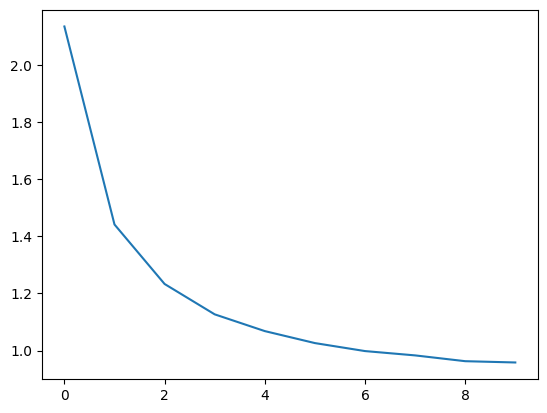

In [ ]:
hidden_size = 128
batch_size = 32

MAX_LENGTH = 10
input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_tokens, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_tokens).to(device)

train(train_dataloader, encoder, decoder, 10, print_every=1, plot_every=1, learning_rate=0.005)

Comente sus resultados. ¿Cómo evoluciona la loss a medida que aumenta el número de epochs?

```
Comentar aquí.
```

Pruebe su traductor con algunas oraciones aleatorias del corpus de test.

In [ ]:
def evaluate_randomly(encoder, decoder, dataset, n=10):
  for i in range(n):
    pair = random.choice(dataset)
    print('Input:', pair[0])
    print('Traducción:', pair[1])
    output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
    output_sentence = ' '.join(output_words)
    print('Predicción:', output_sentence)
    print('')

In [ ]:
encoder.eval()
decoder.eval()
evaluate_randomly(encoder, decoder)

Input: no tengo ni idea de qué me estás hablando
Traducción: i have no clue what you re talking about
Predicción: i don t really feel stupid who are talking about

Input: todavía no le he preguntado a tom
Traducción: i haven t asked tom yet
Predicción: i haven t ever asked tom yet STOP

Input: no deberías gastar más dinero del que ganás
Traducción: you shouldn t spend more money than you earn
Predicción: you shouldn t spend more money than you STOP

Input: todo lo que te hemos contado es cierto
Traducción: everything we ve told you is true
Predicción: you see what you become a true piece STOP

Input: aquí está su paraguas dónde está el mío ?
Traducción: here s your umbrella where s mine ?
Predicción: is the umbrella where the bag is mine ? STOP

Input: no suena cierto
Traducción: it doesn t sound true
Predicción: it sounds not true STOP

Input: no quiero que eso pase
Traducción: i don t want that to happen
Predicción: i don t want that that that that would happen

Input: no hay alguna 

Comente sus resultados. ¿Qué ocurre con las cuando la traducción predicha es válida pero no igual al ground truth? ¿Qué haría para abordar este problema?

```
Comentar aquí.
```

### Visualizando *Attention* (0.5 pt.)

Ahora visualizaremos los pesos de atención asignados entre los pesos de las palabras traducidas. Para esto, cree una función que le permita ver la matriz de pesos de atención entregados por su decoder a partir de una oración.

In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

In [ ]:
%matplotlib inline

In [ ]:
def plot_attention(input_sentence, output_words, attentions):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
  fig.colorbar(cax)

  # Set up axes
  #ax.xaxis.set_ticks(values_list)
  ax.set_xticklabels([''] + input_sentence.split(' ') +
             ['STOP'], rotation=90)
  ax.set_yticklabels([''] + output_words)

  # Show label at every tick
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()


def show_attention(input_sentence):
  output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
  print('input =', input_sentence)
  print('output =', ' '.join(output_words))
  plot_attention(input_sentence, output_words, attentions[0, :len(output_words), :])

Grafique la atención de las siguientes oraciones de ejemplo. Haga lo mismo con al menos tres oraciones más que puedan ser interesantes.

In [ ]:
## Oraciones de ejemplo

show_attention('tom necesita un poco de ayuda')

show_attention('el perro corre rápidamente')

show_attention('el banco le ofreció un alto interés')

show_attention('él toca la flauta el clarinete y el saxofón')

NameError: name 'evaluate' is not defined

input = última tarea del ramo !
output = we were created the decorating of peace ! STOP


/tmp/ipykernel_34/2977807968.py:9: UserWarning:

FixedFormatter should only be used together with FixedLocator

/tmp/ipykernel_34/2977807968.py:11: UserWarning:

FixedFormatter should only be used together with FixedLocator



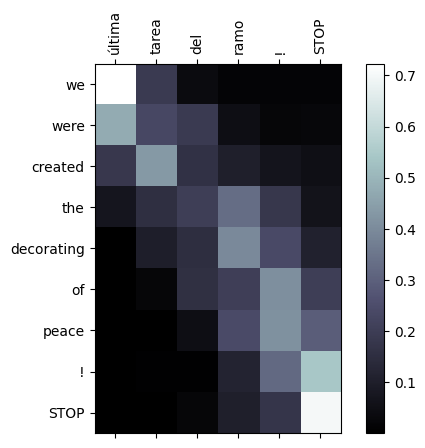

KeyError: ''

In [ ]:
## Oraciones de ejemplo

show_attention('última tarea del ramo !')

show_attention('')

show_attention('')

Comente sus resultados. ¿Eran lo que esperaba?
```
Comentar aquí.
```

## Opcional: BERT

Lo primero es instalar las librerías necesarias.

In [ ]:
%%capture
!pip install transformers
from transformers import BertTokenizer, BertForNextSentencePrediction, BertForMaskedLM, BertForQuestionAnswering
import torch

Para las preguntas que siguen, utilizaremos distintas variantes de BERT disponibles en la librería transformers. [Aquí](https://huggingface.co/transformers/model_doc/bert.html) pueden encontrar toda la documentación necesaria. El modelo pre-entrenado a utilizar es "bert-base-uncased" (salvo para question answering).

BERT es un modelo de lenguaje que fue entrenado exhaustivamente sobre dos tareas: 1) Next sentence prediction. 2) Masked language modeling.

### **BertForNextSentencePrediction**

**Pregunta 1:**  Utilizando el modelo BertForNextSentencePrediction de la librería transformers, muestre cual de las 2 oraciones es **más probable** que sea una continuación de la primera. Para esto defina la función $oracion\_mas\_probable$, que recibe el inicio de una frase, las alternativas para continuar esta frase y retorna un string indicando cual de las dos oraciones es más probable **(0.25 puntos cada una)**.

Por ejemplo:

Initial: "The sky is blue."\
A: "This is due to the shorter wavelength of blue light."\
B: "Chile is one of the world's greatest economies."

Debería retornar "La oración que continúa más probable es A", justificándolo con la evaluación de BERT.



In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForNextSentencePrediction.from_pretrained('bert-base-uncased')

In [ ]:
# Funciones auxiliares:
def oracion_mas_probable(first,sentA,sentB):
  encodingA = tokenizer(first, sentA, return_tensors='pt')
  encodingB = tokenizer(first, sentB, return_tensors='pt')
  outputA = model(**encodingA, labels=torch.LongTensor([1]))
  outputB = model(**encodingB, labels=torch.LongTensor([1]))
  logitsA = outputA.logits
  logitsB = outputB.logits
  #Nota logits[0,0] entrega el score que la oracion si sea la siguiente (que tan True)
  #logits[0,1] entrega el score de que la oracion no sea la siguiente (que tan False)
  # Se puede aplicar una SoftMax sobre estos resultados para que sean probabilidades
  # Pero no es necesario.
  if logitsA[0, 0] > logitsB[0, 0] and logitsA[0, 1] < logitsB[0, 1]:
    print("La oración más probable es A")
  elif logitsB[0, 0] > logitsA[0, 0] and logitsB[0, 1] < logitsA[0, 1]:
    print("La oración más probable es B")
  else:
    print("No está claro cual es más probable")

1.1)
Initial: "My cat is fluffy."\
A: "My dog has a curling tail."\
B: "A song can make or ruin a person’s day if they let it get to them."

In [ ]:
initial = "My cat is fluffy."
sentenceA = "My dog has a curly tail."
sentenceB = "A song can make or ruin a person’s day if they let it get to them."
oracion_mas_probable(initial,sentenceA,sentenceB)

La oración más probable es A


1.2)
Initial: "The Big Apple is famous worldwide."\
A: "You can add cinnamon for the perfect combination."\
B: "It is America's largest city."

In [ ]:
initial = "The Big Apple is famous worldwide."
sentenceA = "You can add cinnamon for the perfect combination."
sentenceB = "It is America's largest city."
oracion_mas_probable(initial,sentenceA,sentenceB)

La oración más probable es B


1.3)
Initial: "Roses are red."\
A: "Violets are blue."\
B: "Fertilize them regularly for impressive flowers."

In [ ]:
initial = "Roses are red."
sentenceA = "Violets are blue."
sentenceB = "Fertilize them regularly for impressive flowers."
oracion_mas_probable(initial,sentenceA,sentenceB)

La oración más probable es A


1.4)
Initial: "I play videogames the whole day."\
A: "They make me happy."\
B: "They make me rage."\

In [ ]:
initial = "I play videogames the whole day."
sentenceA = "They make me happy."
sentenceB = "They make me rage."
oracion_mas_probable(initial,sentenceA,sentenceB)

La oración más probable es A


### **BertForMaskedLM**

**Pregunta 2:**  Ahora utilizaremos BertForMaskedLM para **predecir una palabra oculta** en una oración.\
Por ejemplo:\
BERT input: "I want to _ a new car."\
BERT prediction: "buy"

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')

In [ ]:
# Funcion auxiliar
def palabra_mas_probable(sentence):
  tokenized_text = tokenizer.tokenize(sentence)
  masked_index = tokenized_text.index('[MASK]')
  indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
  tokens_tensor = torch.tensor([indexed_tokens])

  predictions = model(tokens_tensor)
  predicted_index = torch.argmax(predictions[0][0][masked_index]).item()
  predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])[0]
  print(predicted_token)

2.1)
BERT input: "[CLS] I love [MASK] . [SEP]"

In [ ]:
sent = "[CLS] I love [MASK] . [SEP]"
palabra_mas_probable(sent)

you


2.2)
BERT input: "[CLS] I hear that Karen is very [MASK] . [SEP]"

In [ ]:
sent = "[CLS] I heard that Karen is very [MASK] . [SEP]"
palabra_mas_probable(sent)

upset


2.3)
BERT input: "[CLS] She had the gift of being able to [MASK] . [SEP]"

In [ ]:
sent = "[CLS] She had the gift of being able to [MASK] . [SEP]"
palabra_mas_probable(sent)

fly


2.4)
BERT input: "[CLS] It's not often you find a [MASK] on the street. [SEP]"

In [ ]:
sent = "[CLS] It's not often you find an [MASK] on the circus . [SEP]"
palabra_mas_probable(sent)

expert


### **BertForQuestionAnswering**

**Pregunta 3 (1 pto):**  Utilizando el modelo BertForQuestionAnswering pre-entrenado con 'bert-large-uncased-whole-word-masking-finetuned-squad', **extraiga la respuesta** a cada una de las siguientes 4 preguntas y su contexto. **(0.25 puntos cada una)**. Recuerde cambiar el tokenizer para que coincida con el modelo.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

In [ ]:
def entregar_respuesta(qst, cntxt):
  inputs = tokenizer(qst, cntxt, return_tensors='pt')
  outputs = model(**inputs)
  start_scores = outputs.start_logits
  end_scores = outputs.end_logits
  all_tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].tolist())
  answer = all_tokens[torch.argmax(start_scores) : torch.argmax(end_scores)+1]

  print(' '.join(answer))

3.1)

Pregunta: "When was the Battle of Iquique?"

Contexto: "The Battle of Iquique was a naval engagement that occurred between a Chilean corvette under the command of Arturo Prat and a Peruvian ironclad under the command of Miguel Grau Seminario on 21 May 1879, during the naval stage of the War of the Pacific, and resulted in a Peruvian victory."

In [ ]:
q = "When was the Battle of Iquique?"
c = "The Battle of Iquique was a naval engagement that occurred between a Chilean corvette under the command of Arturo Prat and a Peruvian ironclad under the command of Miguel Grau Seminario on 21 May 1879, during the naval stage of the War of the Pacific, and resulted in a Peruvian victory."
entregar_respuesta(q, c)

21 may 1879


3.2)

Pregunta: "Who won the Battle of Iquique?"

Contexto: "The Battle of Iquique was a naval engagement that occurred between a Chilean corvette under the command of Arturo Prat and a Peruvian ironclad under the command of Miguel Grau Seminario on 21 May 1879, during the naval stage of the War of the Pacific, and resulted in a Peruvian victory."

In [ ]:
q = "Who won the Battle of Iquique?"
c = "The Battle of Iquique was a naval engagement that occurred between a Chilean corvette under the command of Arturo Prat and a Peruvian ironclad under the command of Miguel Grau Seminario on 21 May 1879, during the naval stage of the War of the Pacific, and resulted in a Peruvian victory."
entregar_respuesta(q, c)

peruvian


3.3)

Pregunta: "Who introduced peephole connections to LSTM networks?"
Contexto: "What I’ve described so far is a pretty normal LSTM. But not all LSTMs are the same as the above. In fact, it seems like almost every paper involving LSTMs uses a slightly different version. The differences are minor, but it’s worth mentioning some of them. One popular LSTM variant, introduced by Gers & Schmidhuber (2000), is adding “peephole connections.” This means that we let the gate layers look at the cell state."

In [ ]:
q = "Who introduced peephole connections to LSTM networks?"
c = "What I’ve described so far is a pretty normal LSTM. But not all LSTMs are the same as the above. In fact, it seems like almost every paper involving LSTMs uses a slightly different version. The differences are minor, but it’s worth mentioning some of them. One popular LSTM variant, introduced by Gers & Schmidhuber (2000), is adding “peephole connections.” This means that we let the gate layers look at the cell state."
entregar_respuesta(q, c)

ge ##rs & sc ##hmi ##dh ##uber


3.4)

Pregunta: "When is the cat most active?"

Contexto: "The cat is similar in anatomy to the other felid species: it has a strong flexible body, quick reflexes, sharp teeth and retractable claws adapted to killing small prey. Its night vision and sense of smell are well developed. Cat communication includes vocalizations like meowing, purring, trilling, hissing, growling and grunting as well as cat-specific body language. It is a solitary hunter but a social species. It can hear sounds too faint or too high in frequency for human ears, such as those made by mice and other small mammals. It is a predator that is most active at dawn and dusk. It secretes and perceives pheromones."

In [ ]:
q = "When is the cat most active?"
c = "The cat is similar in anatomy to the other felid species: it has a strong flexible body, quick reflexes, sharp teeth and retractable claws adapted to killing small prey. Its night vision and sense of smell are well developed. Cat communication includes vocalizations like meowing, purring, trilling, hissing, growling and grunting as well as cat-specific body language. It is a solitary hunter but a social species. It can hear sounds too faint or too high in frequency for human ears, such as those made by mice and other small mammals. It is a predator that is most active at dawn and dusk. It secretes and perceives pheromones."
entregar_respuesta(q, c)

dawn and dusk
